## Intro 
In previous approaches from notebook 3 we had good validation results from 1 vs many oversmpled classification, and from 5 class oversampled classification, this was most likely due to 2 reasons, first beeing that we had very similar samples in validation and train dataset so the model was already familiar with samples it was about to classify, secondly we increased number of samples and added "noise" using samples generated by SMOTE algorythm, this caused model to learn better. The results were accuracy of 0.6 for the test dataset. That is better result than 0.2 without using oversampling. The issue with the approach we took is that we didnt really used correct from biological perspective classes. In this notebook we will use all ponds from timepoint (tp) 1. and controll from tp 2. as a controll group and classes 1:4 from tp2 as different classes for classification. 

### Import libraries and load data

In [4]:
#libraries import
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
# for tensorboard logs
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import normalize
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, KFold
from functions import *
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE, SMOTEN

np.random.seed(111)
tf.random.set_seed(111)


In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/paq88/Fish_neural_network_classifier/refs/heads/main/sed_based/Data/sed_bacteria_merged.csv')
predictors = df.columns[1:]
print(f"number of predictors/bacteria famillies: {len(predictors)}")
      
# adding collumn with timepoints 
classes = np.tile([0, 1], 25)
df.insert(1,"class_timepoint",  classes)

# replacing NaN values with 0
df.fillna(0, inplace=True)

df.head()




number of predictors/bacteria famillies: 227


,pond,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
0,Sed_S10,0,111.0,128.0,122.0,101.0,84.0,44.0,42.0,52.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Sed_S10,1,18.0,150.0,10.0,129.0,0.0,0.0,30.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Sed_S11,0,81.0,21.0,29.0,90.0,0.0,8.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Sed_S11,1,3.0,13.0,18.0,3.0,0.0,3.0,18.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Sed_S12,0,171.0,67.0,109.0,76.0,23.0,31.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# for normalisation we will use starndard min-max normalisation
df[predictors] = normalize(df[predictors], norm='max', axis=0, copy=True, return_norm=False)
df.describe()

,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,d__Bacteria;p__Cyanobacteria;c__Cyanobacteriia;o__Cyanobacteriales;f__Phormidiaceae,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.500000,0.238804,0.345469,0.125680,0.353059,0.127573,0.167674,0.156283,0.142692,0.223499,...,0.033846,0.022500,0.020000,0.020000,0.030000,0.020000,0.020000,0.020000,0.020000,0.020000
std,0.505076,0.196842,0.256620,0.189293,0.236595,0.211493,0.248427,0.220008,0.221357,0.276172,...,0.170354,0.142163,0.141421,0.141421,0.156818,0.141421,0.141421,0.141421,0.141421,0.141421
min,0.000000,0.000000,0.011719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.086957,0.134766,0.012645,0.195588,0.000000,0.000000,0.000000,0.000000,0.007019,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.222826,0.287109,0.046628,0.332353,0.038835,0.023256,0.053097,0.028846,0.110151,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.343071,0.472656,0.156481,0.470588,0.189320,0.255814,0.247788,0.192308,0.424946,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000




| number | setup | pond numbers | water supplementation | feed supplementation |
|---|---|---|---|---|
|0|control | 8,14,18,24,29|NO|NO|
|1|set 1 | 12,16,19,23,26|Em farma|NO|
|2|set 2 | 10,21,28,30,32|Em farma|EM|
|3|set 3 | 9,13,17,20,27|EM|NO|
|4|set 4 | 11,15,22,25,31|EM|EM|

In [4]:
# Decoding 

codes5 = {0 : [8,14,18,24,29], 1: [12,16,19,23,26], 2 : [10,21,28,30,32], 3 : [9,13,17,20,27], 4 : [11,15,22,25,31]}
codes3 = {0 : [8,14,18,24,29], 1: [12,16,19,23,26, 10,21,28,30,32], 2 : [9,13,17,20,27,11,15,22,25,31]}
df['pond_org'] = df['pond']
df['pond'] = df['pond_org'].apply(lambda x: pond_decoder(x,codes5))

C:\Users\marek\AppData\Local\Temp\ipykernel_21352\792219515.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['pond_org'] = df['pond']


In [5]:
control_id = (df['class_timepoint'] == 0) | ((df['class_timepoint'] == 1) & (df['pond'] == 0))



In [6]:
df.loc[control_id, 'class'] = 0 
df.loc[df['class']!=0,'class'] = df.loc[df['class']!=0,'pond']

C:\Users\marek\AppData\Local\Temp\ipykernel_21352\3401523952.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[control_id, 'class'] = 0


In [7]:
# defragmenting 
df = df.copy()

In [8]:
#train_val_df, test_df = train_test_split(df, test_size= 10, random_state=111, stratify=df['pondXtime'])
#print(train_val_df.shape, test_df.shape)

### Definitions

For crossvalidation purposes we will create 5 subsets of size 10 each, 4 of them will be used as train dataset and one as validating dataset.  This then will be repeated 4 times and validation result will be mean of results.

In [9]:
kf = KFold(n_splits=5, shuffle=True, random_state=111)


In [50]:
# early stopping callback to save the best model weights for test set
es_callback = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=100,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Verbosity mode
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

## Modelling without oversampling


In [11]:
model1 = keras.Sequential()



model1.add(keras.layers.Dense(128,input_shape=(len(predictors),),activation='relu'))


model1.add(keras.layers.Dropout(rate=0.25))
model1.add(keras.layers.Dense(64, activation ='relu'))
model1.add(keras.layers.Dense(16, activation ='relu'))
model1.add(keras.layers.Dropout(rate=0.25))
model1.add(keras.layers.Dense(16, activation ='relu'))

model1.add(keras.layers.Dense(5, activation ='softmax'))

print(model1.summary())


loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model1.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        29,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,837 (151.71 KB)

 Trainable params: 38,837 (151.71 KB)

 Non-trainable params: 0 (0.00 B)

None


Number of classes: 5
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6000 - loss: 1.2941
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
predicted classes:       [0 0 4 0 0 2 2 0 2 0]
true validation classes: [0 0 0 0 0 4 1 0 3 0]
mean confidence score: 65.7294, sd confidence score: 120.1485
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5000 - loss: 3.9704
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
predicted classes:       [0 0 0 0 0 0 0 0 0 0]
true validation classes: [4 0 0 4 3 2 0 0 4 0]
mean confidence score: 628.7877, sd confidence score: 987.6247
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4000 - loss: 6.4318
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
predicted classes:       [0 0 0 0 0 0 0 0 0 0]
true validation classes: [1 0 0 1 4 0 1 0 2 2]
mean confidence score: 15553.0684, sd confidence score: 41708.2604
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5000 - loss: 2.7680
1/1 ━━━━━━━━━━

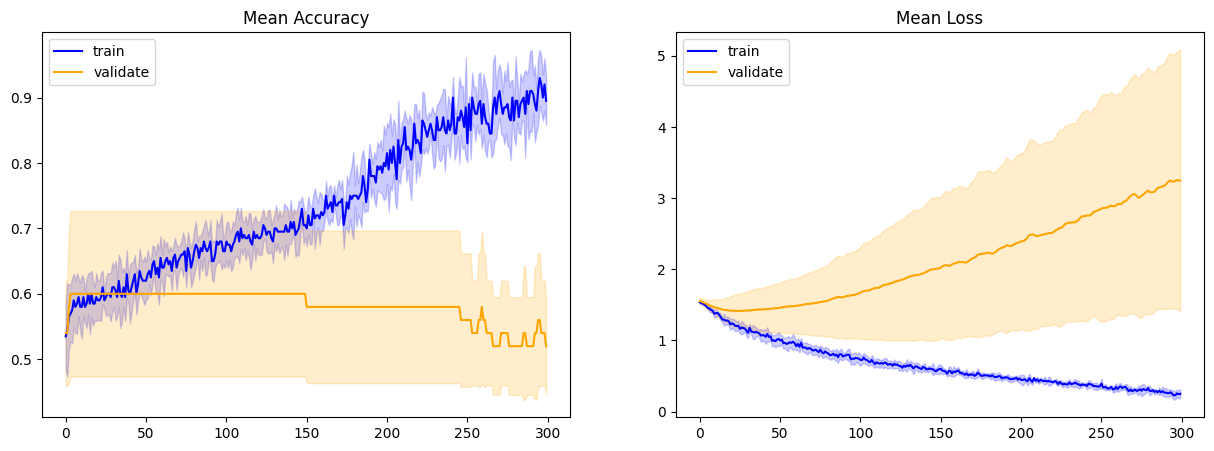

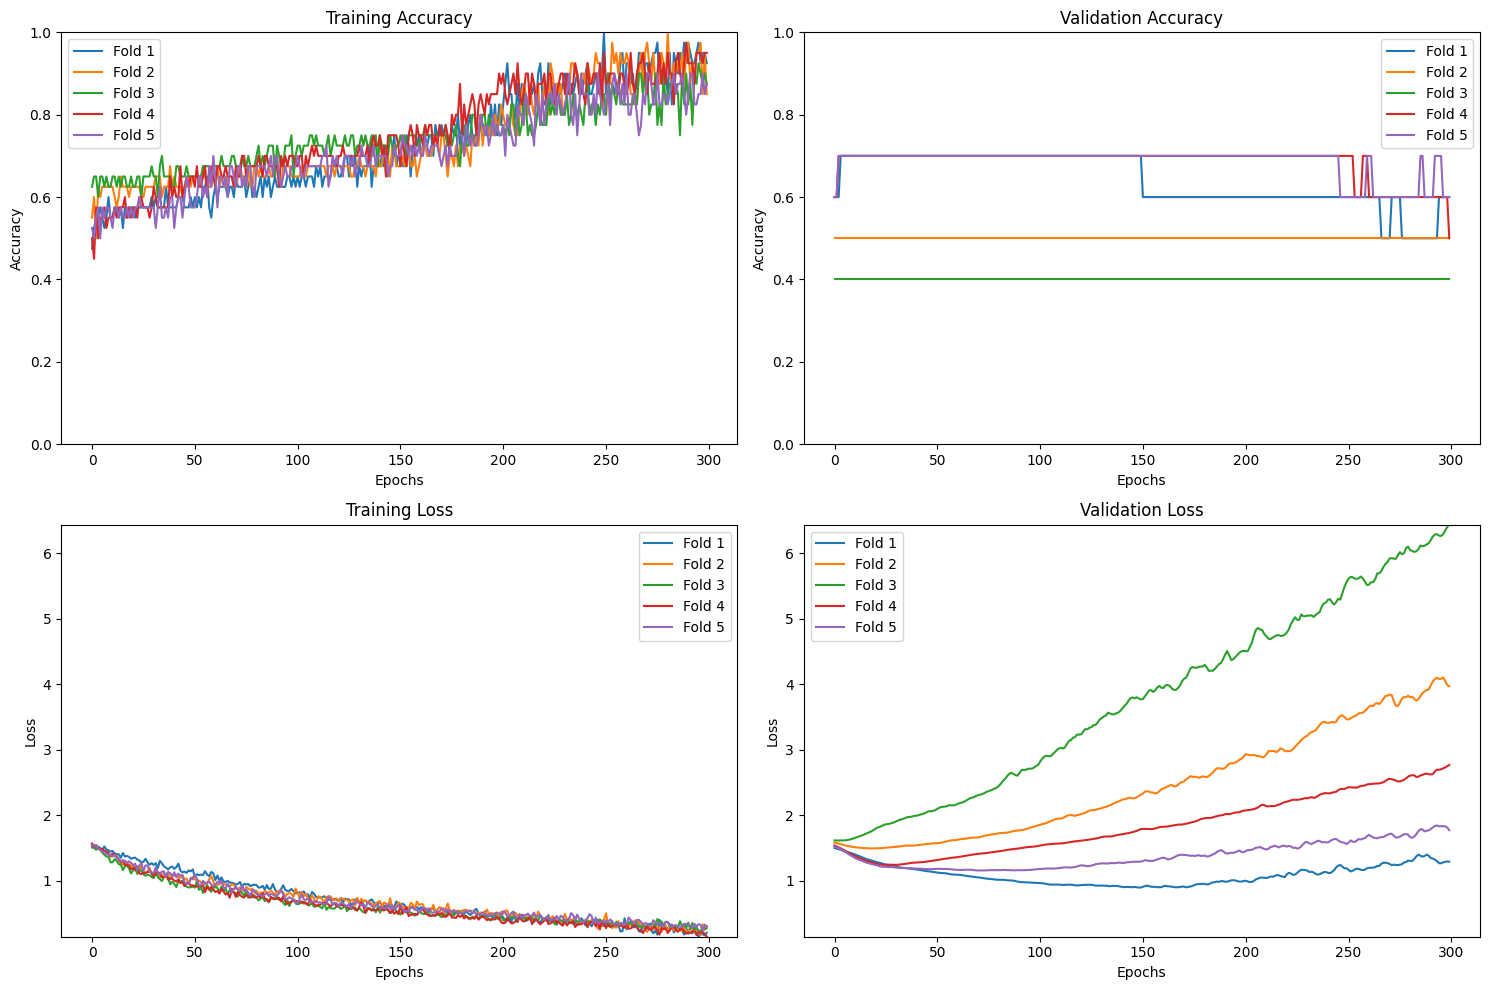

In [12]:
crossvalidate(df, model1, predictors, 'class', kf)

First we need to note that for this classification 60% of samples belong to class controll so by assigning every observation to it model will reach 0.6 accuracy, and this is whats happening for most of the cases, in other cases model is correcttly classifying to controll but missing all the other classes, We will attempt to fix that by oversampling. 

### Oversampling 1:4 classes
For oversampling we will again use SMOTE algorythm as it is more sophisticated than just duplicating.

In [28]:
train_val_df, test_df = train_test_split(df, test_size= 10, random_state=111, stratify=df['class'])
train_val_df.shape, test_df.shape

((40, 231), (10, 231))

In [30]:
smote = SMOTE(random_state=111, sampling_strategy='not majority', k_neighbors=3)
X = train_val_df[predictors].values
y = train_val_df['class']
X_smote, y_smote = smote.fit_resample(X, y)
 

In [31]:
print(X.shape, y.shape)
print(X_smote.shape, y_smote.shape)

(40, 227) (40,)
(120, 227) (120,)


In [32]:
df_smote = pd.concat([pd.DataFrame(X_smote, columns=predictors), pd.DataFrame(y_smote, columns=['class'])], axis=1)
df_smote['class'].value_counts()

class
0.0    24
4.0    24
3.0    24
1.0    24
2.0    24
Name: count, dtype: int64

#### Modeling oversampled dataset

In [33]:
model2 = keras.Sequential()



model2.add(keras.layers.Dense(128,input_shape=(len(predictors),),activation='relu'))


model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(64, activation ='sigmoid'))
model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(16, activation ='sigmoid'))

model2.add(keras.layers.Dense(5, activation ='softmax'))

model2.summary()

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │        29,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,565 (150.64 KB)

 Trainable params: 38,565 (150.64 KB)

 Non-trainable params: 0 (0.00 B)

Number of classes: 5
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8750 - loss: 0.5003
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
predicted classes:       [0 4 3 1 1 2 0 1 2 0 0 1 1 2 3 3 3 3 3 3 3 4 4 4]
true validation classes: [0 4 3 1 1 0 0 0 0 0 0 1 1 2 3 3 3 3 3 3 3 4 4 4]
mean confidence score: 22.2159, sd confidence score: 17.1856
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9167 - loss: 0.3270
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
predicted classes:       [1 2 2 3 1 1 1 1 1 1 1 2 2 2 2 2 3 3 3 3 4 4 4 4]
true validation classes: [0 2 0 3 1 1 1 1 1 1 1 2 2 2 2 2 3 3 3 3 4 4 4 4]
mean confidence score: 27.8149, sd confidence score: 21.1229
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9583 - loss: 0.1784
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
predicted classes:       [3 3 0 2 0 1 1 1 2 2 2 2 3 3 3 3 3 4 4 4 4 4 4 4]
true validation classes: [0 3 0 2 0 1 1 1 2 2 2 2 3 3 3 3 3 4 4 4 4 4 4 4]
mean confid

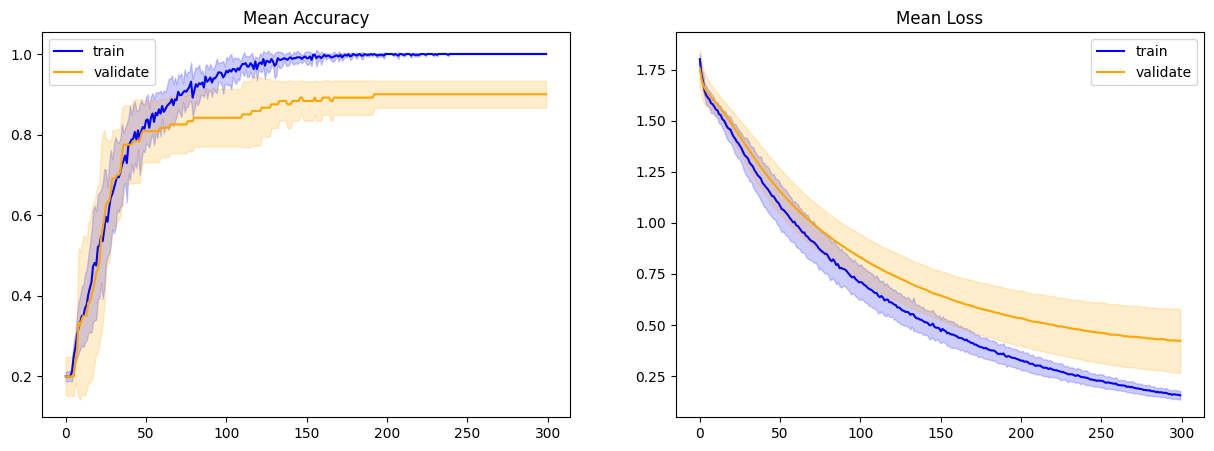

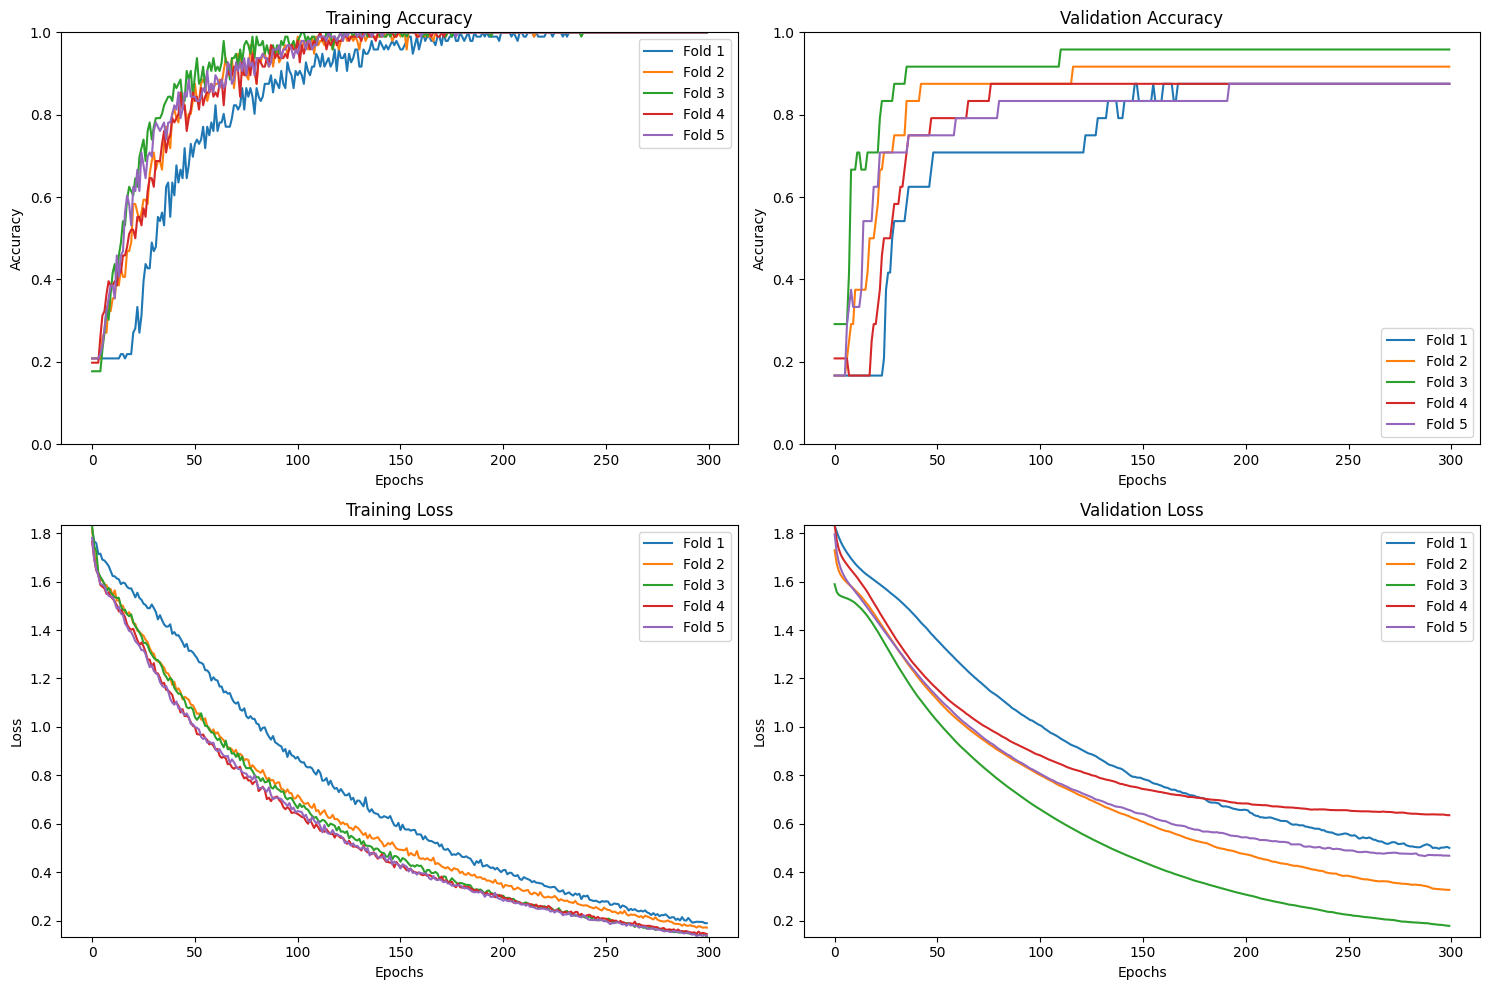

In [34]:
crossvalidate(df_smote, model2, predictors, 'class', kf)

We can see here as in previous notebook that oversampling helped a lot, but there might be a case once again that synthetic samples close to orignal ones, this is especially the case since we lowered number of neighbours to 4 as we didnt have enough samples. To test our model we will use test dataset.

In [51]:
reset_weights(model2)
X_train_val = df_smote[predictors].values
y_train_val = keras.utils.to_categorical(df_smote['class'].values)
X_test = test_df[predictors].values
y_test = keras.utils.to_categorical(test_df['class'].values)
X_train_val.shape, y_train_val.shape, X_test.shape, y_test.shape


((120, 227), (120, 5), (10, 227), (10, 5))

In [52]:
y_test

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [53]:
history2 = model2.fit(X_train_val, y_train_val, validation_data = (X_test, y_test), epochs=500, callbacks=[es_callback], verbose=1)


Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1998 - loss: 1.8528 - val_accuracy: 0.1000 - val_loss: 2.2009
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1998 - loss: 1.8399 - val_accuracy: 0.1000 - val_loss: 2.1871
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1998 - loss: 1.8367 - val_accuracy: 0.1000 - val_loss: 2.1693
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1998 - loss: 1.8403 - val_accuracy: 0.1000 - val_loss: 2.1498
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1998 - loss: 1.8038 - val_accuracy: 0.1000 - val_loss: 2.1299
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1998 - loss: 1.8045 - val_accuracy: 0.1000 - val_loss: 2.1101
Epoch 7/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1998 - loss: 1.7926 - val_accuracy: 0.1000 - val_loss: 2.0909
Epoch 8/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1998 - loss: 1.7629 - val_accuracy: 0.1000 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.0000e+00 - loss: 1.7335
[1.7335424423217773, 0.0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted values: [4 4 3 4 3 4 4 4 2 4]
True values: [1 0 4 0 2 0 0 0 0 3]


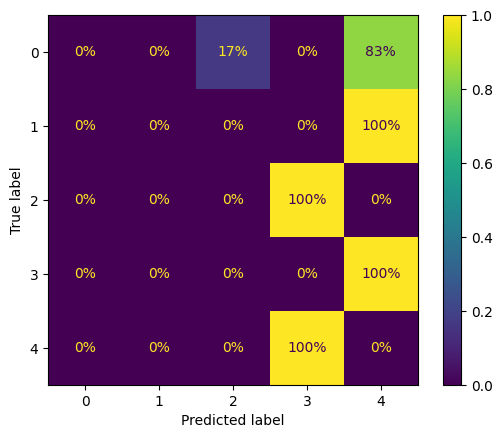

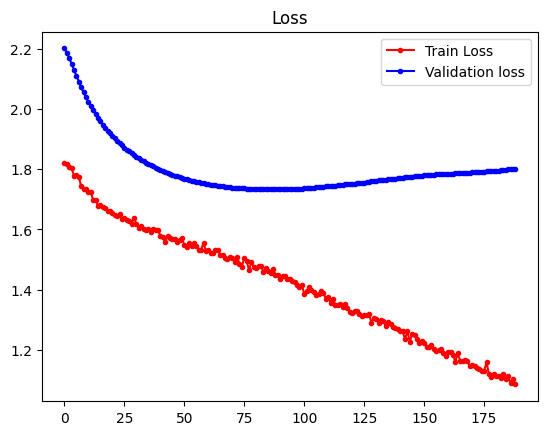

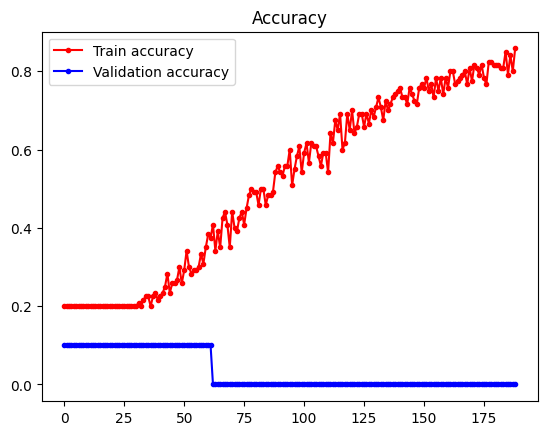

In [54]:
evaluate_model(model2,history2,test_df[predictors] , keras.utils.to_categorical(test_df['class']))

After evaluation on test dataset we can see that results are very poor, cause of that is probably that we only had 3 original samples for classes in training dataset and even with oversampling its just not enough to train model properly, I think with 5 original samples plus noise from oversampling we could have model that is "enough" but i cant really test that. 

## Final conclusions
Across all notebooks, the best test accuracy (0.6) was achieved using both time points without adjusting for time differences and with oversampling applied. However, this result is relatively low. This accuracy was likely limited by the fact that we only had 8 original samples for training, and the lack of adjustment for time differences likely further impacted performance.

In an alternative approach where all samples from timepoint 0 and the control samples from timepoint 1 were labeled as control, and the remaining classes from timepoint 1 were treated as distinct classes, we found that the sample size was insufficient for effective model training. In the next section of this analysis, we will evaluate the best approach for the other datasets to compare results with KEGG and KEGG Orthology datasets.